# Quadratic Embeddings for 2D-Burgers equations with Shock


Copyright (c) 2022 Pawan Goyal

All rights reserved.

This source code is licensed under the MIT license found in the LICENSE file in the root directory of this source tree.

@author: [Pawan Goyal](mailto:goyalp@mpi-magdeburg.mpg.de)

#### Include important packages (Note that a virtual envionment can be created using enviornment.yml, containing all required libraries to run the notebook)


In [1]:
import os, sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader
from scipy.integrate import solve_ivp
from dataclasses import dataclass

sys.path.append( os.path.dirname( os.path.abspath('') ) )

import Functions.utils as utils
import Functions.data_loading as data_loading
import Functions.modules as modules
from Functions.Approx_derivative import xdot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    print('No GPU found!')
else:
    print('Great, a GPU is there')

No GPU found!


### Define the seed to reproduce results

In [2]:
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # gpu vars
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Define variabels and parameters

In [3]:
@dataclass
class parameters:
    logging_root: str = './logs' # folder where log file will be saved
    experiment_name: str = './burgers2D/' # Experiment name
    lr : float = 1e-3 # learning rate
    ##
    num_epochs: int = 15000 # Number of epochs for training
    steps_til_summary: int = 5000 # Number of epochs after which a summary of training will be printed
    ## 
    dim_reduced = 1 # Dimension of the embeddings
    ##
    models_loading= True # Set to True if existing models need to be loaded
    models_training = False # Set to True if models need to be trained 

opt = parameters()

### Loading data

In [4]:
root_path = os.path.join(opt.logging_root, opt.experiment_name)

dataset = data_loading.Data_Burgers2D_OpInf()
dataloader = DataLoader(dataset, shuffle=True, batch_size=1, num_workers=0)

grid_info = {'tlen': len(dataset.t), 'tmax': dataset.t.max(), 'dim_out': dataset.u_vec.shape[-1], 'dt': (dataset.t[1] - dataset.t[0]).item()}
print('Temporal points:                    {}'.format(grid_info['tlen']))
print('Max time:                           {}'.format(grid_info['tmax']))
print('Time-stepping (dt):                 {:.4f}'.format(grid_info['dt']))
print('# of grid points (one direction):   {}'.format(grid_info['dim_out']))

Temporal points:                    101
Max time:                           1.0
Time-stepping (dt):                 0.0100
# of grid points (one direction):   512


### Define encoder, decoder, and quadratic model

In [5]:
# defining models
models = {'quad_model': modules.QuadModel(dim_x = opt.dim_reduced, zero_init = True, 
                                               print_model = False).to(device),
          'encoder': modules.encoder_NN_Burgers2D(dim_reduced = opt.dim_reduced, in_channels = 1, dim_afterconv=16*16*64, print_model = False).to(device),
          'decoder': modules.decoder_NN_Burgers2D(dim_reduced = opt.dim_reduced, dim_afterconv = 16*16*64, print_model = False, num_vars = 1, out_channels = 1, only_Linear = False).to(device)
         }

# Define the loss
loss_fns = {'sol_predModel': utils.function_mse, 
            'quad_model': utils.simple_mse,
           }

# Define optimizer
optim = torch.optim.Adam([
                {'params': models['encoder'].parameters(), 'lr': opt.lr, 'weight_decay': 1e-6},
                {'params': models['decoder'].parameters(), 'lr': opt.lr, 'weight_decay': 1e-6},
                {'params': models['quad_model'].parameters(), 'lr': opt.lr*5, 'weight_decay': 0.0},
            ])

## Training encoder, decoder and quadratic-model simultanously 

In [6]:
if opt.models_training:
    train_opInf_autoenc(models=models, train_dataloader=dataloader, 
                      epochs=opt.num_epochs,steps_til_summary=opt.steps_til_summary, 
                      model_dir=root_path, loss_fn=loss_fns, optim = optim, grid_info=grid_info, decay_scheduler = True, RK_params = 1)

if opt.models_loading:
    models['quad_model'].load_state_dict(torch.load('./trained_models/burgers2D/quadModel.pth',map_location=torch.device('cpu')))
    models['encoder'].load_state_dict(torch.load('./trained_models/burgers2D/model_encoder.pth',map_location=torch.device('cpu')))
    models['decoder'].load_state_dict(torch.load('./trained_models/burgers2D/model_decoder.pth',map_location=torch.device('cpu')))

### Further polishing of quadratic model
We approximate the integral using a Runge-Kutta scheme to obtain a quadratic model. To resolve error due to the approximation, we perform a classical operator inference on the obtained embeddings using the trained encoder. 

In [7]:
with torch.no_grad():
    model_input, gt  =  next(iter(dataloader))
    model_input = {key: value.to(device) for key, value in model_input.items()}
    gt = {key: value.to(device) for key, value in gt.items()}
    enc_output = models['encoder'](gt['func'][0])

    Mus= enc_output.mean(dim=0)
    Sigmas = enc_output.std(dim=0)

    dec_output = models['decoder'](enc_output)
    x = enc_output.detach().cpu().numpy()
    dx = xdot(x.T, grid_info['dt'], order=4).T

    x_kron = np.zeros((x.shape[0], x.shape[1]**2))

    for i in range(x.shape[0]):
        x_kron[i] = np.kron(x[i], x[i])

    x_total = np.concatenate((x,x_kron, np.ones((x.shape[0],1))),axis=-1)
    x.shape, grid_info['dt'], dx.shape, x_kron.shape, x_total.shape

    Q, R = np.linalg.qr(x_total)
    sol = np.linalg.inv(R + 1e-3*np.eye(R.shape[0]))@ Q.T@ dx

    A_OINN = sol.T[:,:opt.dim_reduced]
    H_OINN = sol.T[:,opt.dim_reduced:-1]
    B_OINN = sol.T[:,-1]

## Obtain a low-dimensional quadratic model using linear projection (classical operator inference [Peherstorfer/Willcox '16])

In [8]:
########################################################################################################
## Since the model from the linear projection is unstable, we do not simulate here
########################################################################################################

# _,y = next(iter(dataloader))
# UU = y['func'][0].reshape(grid_info['tlen'],-1)
# U,S,V = torch.svd(UU)
# UU.shape, U.shape, S.shape, V.shape

# U_approx = UU@ V[:,:opt.dim_reduced] @ V[:,:opt.dim_reduced].T
# x_pod = (UU@ V[:,:opt.dim_reduced]).detach().cpu().numpy()

# dx_pod = xdot(x_pod.T, grid_info['dt'], order=4).T

# x_pod_kron = np.zeros((x_pod.shape[0], x_pod.shape[1]**2))

# for i in range(x.shape[0]):
#     x_pod_kron[i] = np.kron(x_pod[i], x_pod[i])

# x_pod_total = np.concatenate((x_pod,x_pod_kron, np.ones((x_pod.shape[0],1))),axis=-1)

# Q, R = np.linalg.qr(x_pod_total)
# sol_pod = np.linalg.inv(R + 1e-4*np.eye(R.shape[0]))@ Q.T@ dx_pod
# A_OI = sol_pod.T[:,:opt.dim_reduced]
# H_OI = sol_pod.T[:,opt.dim_reduced:-1]
# B_OI = sol_pod.T[:,-1]

In [9]:
def quad_model(x, t, A, H, B):
    return A@x + H@(np.kron(x,x)) + B

## Compare the models with the high-fidelity model by interating using an ODE solver

In [10]:
x0 = enc_output[0].cpu().detach().numpy()
ts = dataset.t

sol = solve_ivp(lambda t, x: quad_model(x, t, A_OINN, H_OINN, B_OINN), [ts[0], ts[-1]], x0, t_eval=ts.reshape(-1,))
x_pred_OINN = sol.y.T
dec_output_OINN = models['decoder'](torch.from_numpy(x_pred_OINN).float().to(device))

########################################################################################################
## Since the model from the linear projection is unstable, we do not simulate here
########################################################################################################
# x0_pod  = x_pod[0] 
# sol_pod = solve_ivp(lambda t, x: quad_model(x, t, A_OI, H_OI, B_OI), [ts[0], ts[-1]], x0_pod, t_eval=ts.reshape(-1,))
# x_pred_OI = sol_pod.y.T
# dec_output_OI = (x_pred_OI@ V[:,:opt.dim_reduced].T.cpu().detach().numpy())

## Plotting figures

#### Plotting the dynamics of the embeddings

[Text(0.5, 1.0, 'Embeddings'),
 Text(0, 0.5, '$\\hat x(t)$'),
 Text(0.5, 0, 'Time ($t$)')]

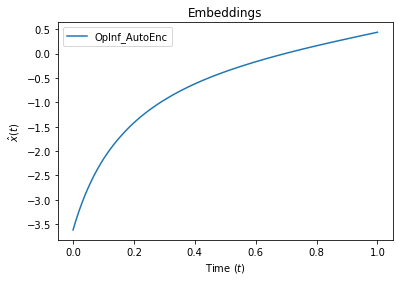

In [11]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(ts,x_pred_OINN, label = 'OpInf_AutoEnc');
ax.legend()
ax.set(title = "Embeddings", ylabel = "$\hat x(t)$", xlabel = "Time ($t$)")

#### Plotting dynamics on the high-dimensional spatial space

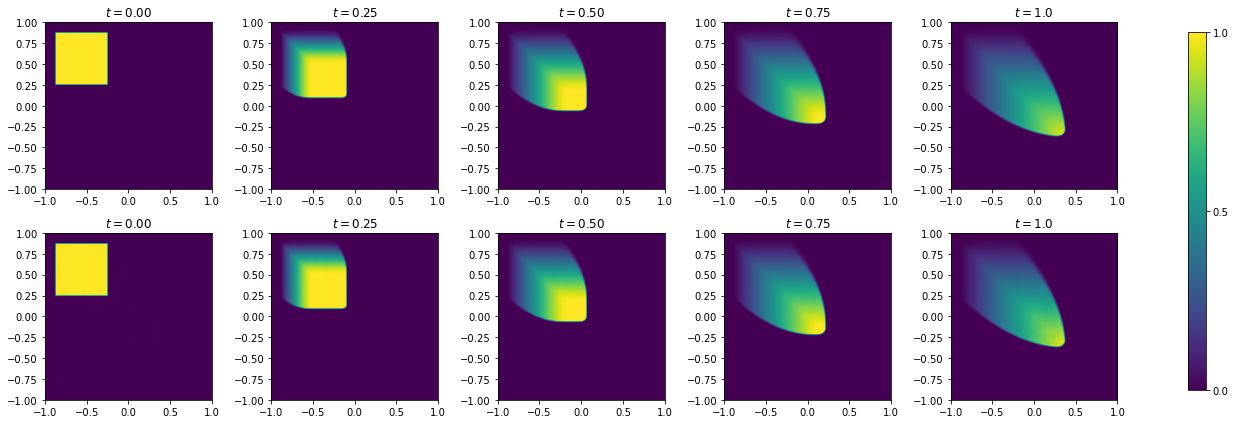

In [12]:
if not os.path.exists("./logs/" + opt.experiment_name):
    os.makedirs("./logs/" + opt.experiment_name)
    
model_input, gt  =  next(iter(dataloader))
model_input = {key: value.to(device) for key, value in model_input.items()}
gt = {key: value.to(device) for key, value in gt.items()}

fig, axs = plt.subplots(2, 5, figsize=(20,6))
im1 = axs[0][0].imshow(gt['func'][0][0][0].cpu().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im2 = axs[0][1].imshow(gt['func'][0][25][0].cpu().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im3 = axs[0][2].imshow(gt['func'][0][50][0].cpu().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im4 = axs[0][3].imshow(gt['func'][0][75][0].cpu().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im5 = axs[0][4].imshow(gt['func'][0][100][0].cpu().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])

im11 = axs[1][0].imshow(dec_output_OINN[0][0].cpu().detach().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im21 = axs[1][1].imshow(dec_output_OINN[25][0].cpu().detach().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im31 = axs[1][2].imshow(dec_output_OINN[50][0].cpu().detach().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im41 = axs[1][3].imshow(dec_output_OINN[75][0].cpu().detach().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])
im51 = axs[1][4].imshow(dec_output_OINN[100][0].cpu().detach().numpy(),vmin=0, vmax=1, extent=[-1,1,-1,1])


axs[0][0].set_title('$t = 0.00$')
axs[0][1].set_title('$t = 0.25$')
axs[0][2].set_title('$t = 0.50$')
axs[0][3].set_title('$t = 0.75$')
axs[0][4].set_title('$t = 1.0$')

axs[1][0].set_title('$t = 0.00$')
axs[1][1].set_title('$t = 0.25$')
axs[1][2].set_title('$t = 0.50$')
axs[1][3].set_title('$t = 0.75$')
axs[1][4].set_title('$t = 1.0$')

fig.tight_layout()
cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.95)
cbar.set_ticks(np.arange(0, 1.1, 0.5))
plt.show()

fig.savefig("./logs/" + opt.experiment_name + "Burgers2D_Compare.pdf", bbox_inches = 'tight',pad_inches = 0)
fig.savefig("./logs/" + opt.experiment_name + "Burgers2D_Compare.png", bbox_inches = 'tight',pad_inches = 0)